In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import scipy as sp

In [2]:
#load csv of surfsessions in a given location

In [3]:
#return individual ride ids as a list
#for example:
#ids = ocean_df['ride_ids']
#ids.drop_duplicates(keep='first')

In [4]:
#ride_ids = ids.to_list()

In [5]:
#ride_ids = [15692, 15693, 15694, 15695] #will be changed by cell above
ride_ids = [15692]

#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
# fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
# str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
# str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper


# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below to get csv id 
str_id_csv = 'img id="temperatureChart" class="chart" src="' 


def get_csv_from_ride_id(rid):
    
# step 1    
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
#     print("ride_url: " + ride_url)
    
# step 2
    # query smartfin website to retrieve the ride's webpage in HTML  
    html_contents = requests.get(ride_url).text
#     print("html contents: ", html_contents)
    
    # Find CSV file location id in html page by csv file tag
    loc_csv_id = html_contents.find(str_id_csv)
#     print("loc_csv_id: ", loc_csv_id)
    
# step 3
    # log into smartfin website to get request authentication
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]

# step 4
    # use csv id and authentication offsets to build query string
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
#     print("csv_id_longstr: ", csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything

# step 5
        # full urls to get csv file       
        ocean_csv_url = f'https://surf.smartfin.org/{csv_id_longstr}Ocean.CSV'
        motion_csv_url = f'https://surf.smartfin.org/{csv_id_longstr}Motion.CSV'
        
        print("ocean_csv_url: ", ocean_csv_url)
        print("motion_csv_url: ", motion_csv_url)
        print('\n\n')

# step 6
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])


# step 7
        # 7a. add elasped column to show how much time has elapsed since first reading
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        print("motion_df_small raw: ", motion_df_small)
        print('\n\n')
        print("ocean_df_small raw: ", ocean_df_small)
        print('\n\n')


        
        # 7b. make the index of each df the timestamp
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print("ocean_df_small length pre upsample: ", len(ocean_df_small))
            print("motion_df_small length pre upsample: ", len(motion_df_small))
            
            # 7c. resample data to 33ms intervals (30 Hz)
            #(changed to 1Hz)
            #May need to change this sampling interval:
            sample_interval = '1000ms' #original 33ms
                        
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
    
            
            print('ocean_df_resample length: ', len(ocean_df_small_resample))
            print('motion_df_resample length: ', len(motion_df_small_resample))
            print('\n\n')
            
            # returns all rows that have values in latitude column           
            # No need to save many extra rows with no fix
            # motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    # if dataframe is empty, just return empty dataframe    
    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    
    
    
    
# actual script

appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0      # number of dataframes with non empty data
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    print("rid: ", rid)
    try:
        # runs code from function defined above
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        
        # for each non empty df, append to list of already created dataframes        
        if not new_ocean_df.empty: # Calibration rides, for example
            
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame
# keys for each diferent dataframe in the big dataframes
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed

# concatinate all dataframes in each list into one big dataframe
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 



# 7d. clear na values from dataframes
#Drop the latitude and longitude values since most of them are Nan:
print('motion df length pre na drop: ', len(motion_df))
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])

#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print('motion_df_dropped length post na drop: ', len(motion_df_dropped))
print('\n\n')

# finished clean dataframes
print('motion_df_dropped: ', motion_df_dropped)
print('ocean_df: ', ocean_df)


rid:  15692
ocean_csv_url:  https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
motion_csv_url:  https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Motion.CSV



motion_df_small raw:                                     UTC        Time  IMU A1  IMU A2  IMU A3  \
0     2018-11-09 19:16:03.806000+00:00  1414742884     NaN     NaN     NaN   
1     2018-11-09 19:16:03.809000+00:00  1414742887   493.0    48.0   110.0   
2     2018-11-09 19:16:04.061000+00:00  1414743138   513.0    89.0    62.0   
3     2018-11-09 19:16:04.312000+00:00  1414743387   494.0    92.0    80.0   
4     2018-11-09 19:16:04.565000+00:00  1414743639   421.0   205.0  -104.0   
...                                ...         ...     ...     ...     ...   
22552 2018-11-09 20:38:14.334000+00:00  1419643689   501.0   -11.0    99.0   
22553 2018-11-09 20:38:14.500000+00:00  1419643854     NaN     NaN     NaN   
22554 2018-11-09 20

In [6]:
motion_df1 = motion_df.drop(columns=['Latitude', 'Longitude', 'Time', 'IMU A1', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3'])
motion_df2 = motion_df1.dropna()
motion_df2

IMU A2
ride_id UTC                              
15692   2018-11-09 19:16:03+00:00   48.00
        2018-11-09 19:16:04+00:00  173.00
        2018-11-09 19:16:05+00:00  331.00
        2018-11-09 19:16:06+00:00  382.50
        2018-11-09 19:16:07+00:00  426.00
...                                   ...
        2018-11-09 20:38:11+00:00   -1.75
        2018-11-09 20:38:12+00:00   -8.50
        2018-11-09 20:38:13+00:00  -11.25
        2018-11-09 20:38:14+00:00  -11.50
        2018-11-09 20:38:15+00:00  -11.00

[4933 rows x 1 columns]

In [7]:
motion_df3 = motion_df2['IMU A2'].divide(512) * 9.80665 + 9.80665
#motion_df3.drop
motion_df3.rename(index={'ride_id': 'ID'})
print(motion_df3.head())

ride_id  UTC                      
15692    2018-11-09 19:16:03+00:00    10.726023
         2018-11-09 19:16:04+00:00    13.120225
         2018-11-09 19:16:05+00:00    16.146496
         2018-11-09 19:16:06+00:00    17.132907
         2018-11-09 19:16:07+00:00    17.966089
Name: IMU A2, dtype: float64


In [8]:
x = list(range(0, len(motion_df3)))
y = motion_df3.to_list()

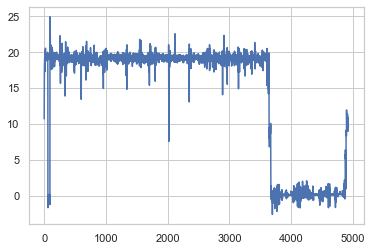

In [9]:
plt.plot(x, y)

In [10]:
sp.integrate(y)

TypeError: 'module' object is not callable

In [ ]:
columnsNamesArr = motion_df3.columns.values
columnsNamesArr

In [ ]:
motion_df3.to_csv('motion.csv')

In [ ]:
import scipy.integrate as it
velocity = it.cumtrapz(y,x, initial=0)
location = it.cumtrapz(velocity,initial=0)
print('velocity: ' + str(velocity))
print('location: ' + str(location))
np.mean(location)